## The predictor

Finally we've reached it, after 3 notebooks passed blabbering (it was a long winded talk, but we assure you that's roughly 1.5 months of our work) about data extraction we're ready to create our predictor!

First we load our regression data and the graph data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

graph = None
with open('graph.pickle', 'rb') as handle:
    graph = pickle.load(handle)

points, _, connect_to, connect_from = graph


with open('samples_train.pickle', 'rb') as handle:
    train_samples = pickle.load(handle)

Next, since we've bloody fought for it, we take a nice look at our work so far in the shape of a heatmap

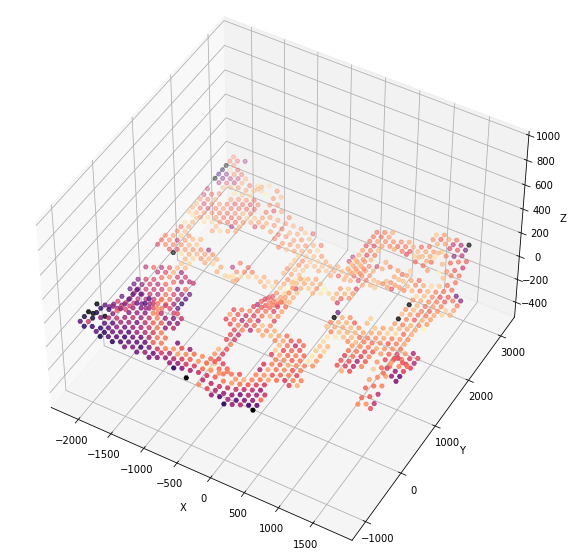

In [6]:
azim = -60
elev = 45

np_points = np.array(points).T
n_samples = np.asarray([samples.shape[0] for samples in train_samples])
mmin = np.min(n_samples)
mmax = np.max(n_samples)
n_samples = np.log((n_samples - mmin) / (mmax - mmin) + 1e-4)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(np_points[0], np_points[1], np_points[2], c=n_samples, cmap="magma", marker="H")


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-500, 1000)

ax.azim = azim
ax.elev = elev

plt.title("Samples distribution")

plt.show()

Interesting, as we can see there is a couple of zones which are clearly used far less by the players, but then we can also see some cells which are essentially unused in the middle of hot zones. How come?

Even though we were really careful in the creation of our graph it is far from perfect: thus those solitary points at the edges which are fully purple in the middle of yellows are probably like that because in reality they do not really represent well the map (they could be inside buildings). Is this a problem? Not really, our reasoning is that, if a cell is not used in the regression data, then most probably it will neither have instances in the test data and not see that much use in general gameplay, thus it is not a problem if we model it badly (or do not model it at all).


Now that we have the data and the structure you know what happens right? We build our regressors!

Of course though, even though we did build a gamma GLM by hand for one of the homeworks, we'll exploit `statsmodels`, for two main reasons:

1. For sure their version is much better than what we may ever come up with.
2. Do we really want to reinvent the wheel?

Now, what did we come up with?
It's complicated.

You see, as the previous plot shows, there is a number of cells which have a lot of data, while others do not. Thus to make our machinery we decided (following the idea that where we find high frequency of samples we'll need higher accuracy but we'll be able to gain it BECAUSE of THAT higher frequency) to build a number of different regressors at different numbers of explanatory variables (less variables entails that less data is needed to do the regression) such that each higher-level model contains the lower ones (exploiting the fact that $R^2$ is monotone increasing as the set of explanatory variables increases itself).

In [ ]:
import statsmodels.api as sm

# DO NOT RUN THIS CELL, (UNLESS YOU WANT TO WAIT 30 MINS FOR IT TO EXEC)
#   THE REGRESSIONS ARE ALREADY STORED IN THEIR OWN .pickles


# results = list()
# for i,samples in enumerate(train_samples):
#     print(i)
#     try:
#         logit_mod = sm.MNLogit.from_formula(formula='choice ~ 1', data=samples)
#         results.append(logit_mod.fit_regularized(disp=0))
#     except:
#         results.append(None)

# # choice ~ 1
# with open('regressions/null.pickle', 'wb') as handle:
#     pickle.dump(results, handle)



# results = list()
# for i,samples in enumerate(train_samples):
#     print(i)
#     try:
#         logit_mod = sm.MNLogit.from_formula(formula='choice ~ team', data=samples)
#         results.append(logit_mod.fit_regularized(disp=0))
#     except:
#         results.append(None)

# # choice ~ team
# with open('regressions/team.pickle', 'wb') as handle:
#     pickle.dump(results, handle)



# results = list()
# for i,samples in enumerate(train_samples):
#     print(i)
#     try:
#         logit_mod = sm.MNLogit.from_formula(formula='choice ~ cell_from', data=samples)
#         results.append(logit_mod.fit_regularized(disp=0))
#     except:
#         results.append(None)

# # choice ~ cell_from
# with open('regressions/from.pickle', 'wb') as handle:
#     pickle.dump(results, handle)



# results = list()
# for i,samples in enumerate(train_samples):
#     print(i)
#     try:
#         logit_mod = sm.MNLogit.from_formula(formula='choice ~ cell_from * team', data=samples)
#         results.append(logit_mod.fit_regularized(disp=0))
#     except:
#         results.append(None)

# # choice ~ cell_from * team
# with open('regressions/from_team.pickle', 'wb') as handle:
#     pickle.dump(results, handle)



# results = list()
# for i,samples in enumerate(train_samples):
#     print(i)
#     try:
#         logit_mod = sm.MNLogit.from_formula(formula='choice ~ cell_from * team + dir_team', data=samples)
#         results.append(logit_mod.fit_regularized(disp=0))
#     except:
#         results.append(None)

# # choice ~ cell_from * team + dir_team
# with open('regressions/from_team_dir.pickle', 'wb') as handle:
#     pickle.dump(results, handle)

As you may have noticed we didn't use the `n_alive` variable... that's because we tried to and the regressor took roughly 8 hours to run, and only 2 cells had a functional regressor...

Now that we've regressed a number of models (each bigger one containing the lower ones) we can give a look at their statistics: we thought a bunch about the best course of action for this part and in the end we resolved into giving averages.

A disclaimer: the $R^2$ presented by the `summary()` for MNLogit functions in statmodels is not the usual $R^2$, but it is instead calculated as McFadden's pseudo-$R^2$, the thing with this value is that it is (allegedly) thought to be pretty good even when its values are between 0.2 and 0.4, thus don't expect high values!

Furthermore, before doing the averages, we will try to calculate the *adjusted* McFadden's pseudo-$R^2$, because of course each cell has a different number of `cell_from` than others and thus the possible number of explanatory variables per cell changes even in the same type of regressor (not to mention that in this way we can compare different regressors against one another).

The McFadden $R^2$ is calculated as:

$$
R^2_{\mathrm{McFadden}} = 1 - \frac{\log(L_c)}{\log(L_\mathrm{null})}
$$

And the adjusted McFadden $R^2$ is:

$$
R^2_{\mathrm{McFadden, adj}} = 1 - \frac{\log(L_c) - K}{\log(L_\mathrm{null})} = R^2_{\mathrm{McFadden}} + \frac{K}{\log(L_\mathrm{null})}
$$

Where $K$ is the total number of explanatory variables (minus the intercept).

Fortunately `statsmodels` exposes `llnull`, a parameter which returns $\log(L_\mathrm{null})$, in this way the only thing we are left to compute is $K$, which changes based on the regression type.

Of course we run this average for each model (except the null one, its $R^2$ is trivially zero).

#### WARNING, each of these cells takes a couple of minutes to run

In [58]:
# Just team
with open('regressions/team.pickle', 'rb') as handle:
    results = pickle.load(handle)

ssum = 0
adj_sum = 0
n = 0

for i in range(len(points)):
    if results[i] != None:
        ssum += results[i].prsquared
        adj_sum += results[i].prsquared + 2 / results[i].llnull
        n += 1


print(f"Just team avg: R^2 {ssum / n:.5f}     adj R^2 {adj_sum / n:.5f}")

Just team avg: R^2 0.05125     adj R^2 0.02680


Mmmm, 0.03 isn't promising...

In [59]:
# Just from
with open('regressions/from.pickle', 'rb') as handle:
    results = pickle.load(handle)

ssum = 0
adj_sum = 0
n = 0

for i in range(len(points)):
    if results[i] != None:
        ssum += results[i].prsquared
        adj_sum += results[i].prsquared + len(connect_from[i]) / results[i].llnull
        n += 1


print(f"Just from avg: R^2 {ssum / n:.5f}     adj R^2 {adj_sum / n:.5f}")

Just from avg: R^2 0.20850     adj R^2 0.18821


Uhhhh, 0.19 is much better.

In [60]:
# Team and from
with open('regressions/from_team.pickle', 'rb') as handle:
    results = pickle.load(handle)

ssum = 0
adj_sum = 0
n = 0

for i in range(len(points)):
    if results[i] != None:
        ssum += results[i].prsquared
        adj_sum += results[i].prsquared + 2 * len(connect_from[i]) / results[i].llnull
        n += 1


print(f"Team and from avg: R^2 {ssum / n:.5f}     adj R^2 {adj_sum / n:.5f}")

Team and from avg: R^2 0.22950     adj R^2 0.20394


.2? That's nice.

In [61]:
# Team and from
with open('regressions/from_team_dir.pickle', 'rb') as handle:
    results = pickle.load(handle)

ssum = 0
adj_sum = 0
n = 0

for i in range(len(points)):
    if results[i] != None:
        ssum += results[i].prsquared
        adj_sum += results[i].prsquared + (2 * len(connect_from[i]) + 1) / results[i].llnull
        n += 1


print(f"Team, from and dir avg: R^2 {ssum / n:.5f}     adj R^2 {adj_sum / n:.5f}")

Team, from and dir avg: R^2 0.24642     adj R^2 0.21381


.21, that's a bit better than before, but nothing too special, just a 0.006 jump (fortunately... as we'll see this last regressor couldn't be used)

After these results we decide that the best course of action is, for each cell, to use the highest quality regressor we have, regardless on if the variables give just a very tiny increase or a big one, because the task at hand is pretty difficult and we need everything that we can lay our hands on (after all we've already collected all this data, wouldn't make sense to not use it to the fullest).

Let's make this frankenstein-like regressor:

#### WARNING, this cell too takes a couple of minutes to run (there's already a stored version of the result that will be loaded in the next cell)

In [62]:
comp_results = []

with open('regressions/from_team.pickle', 'rb') as handle:
    comp_results.append(pickle.load(handle))
with open('regressions/from.pickle', 'rb') as handle:
    comp_results.append(pickle.load(handle))
with open('regressions/team.pickle', 'rb') as handle:
    comp_results.append(pickle.load(handle))
with open('regressions/null.pickle', 'rb') as handle:
    comp_results.append(pickle.load(handle))


results = []
count_each = [0] * len(comp_results)
r2sum = [0] * len(comp_results)
adj_r2sum = [0] * len(comp_results)
totr2sum = 0
totadj_r2sum = 0
for i in range(len(points)):
    k = 0
    while comp_results[k][i] == None and k < len(comp_results) - 1:
        k += 1

    if comp_results[k][i] != None:
        count_each[k] += 1

        r2 = comp_results[k][i].prsquared
        adj_r2 = 0
        if k == 0:
            adj_r2 = comp_results[k][i].prsquared + 2 * len(connect_from[i]) / comp_results[k][i].llnull
        elif k == 1:
            adj_r2 = comp_results[k][i].prsquared + len(connect_from[i]) / comp_results[k][i].llnull
        elif k == 2:
            adj_r2 = comp_results[k][i].prsquared + 2 / comp_results[k][i].llnull
        else:
            adj_r2 = comp_results[k][i].prsquared # same as non-adjusted

        r2sum[k] += r2
        adj_r2sum[k] += adj_r2
        totr2sum += r2
        totadj_r2sum += adj_r2

        results.append(comp_results[k][i])
    else:
        results.append(None)

s = 0
for res in results:
    if res == None:
        s += 1

count_each = np.asarray(count_each)
avg_r2 = np.asarray(r2sum) / count_each
avg_adj_r2 = np.asarray(adj_r2sum) / count_each

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.3f}'.format})

print(f"Number w/out regressions: {s}")
tot = count_each.sum()
print(f"Total number of regressions: {count_each.sum()}")
print("  - Quantities are in descending order of quality -")
print(f"Number for each: {count_each}")
print(f"Avg. R^2 for each: {avg_r2}, adjusted {avg_adj_r2}")
print(f"Total avg. R^2: {totr2sum / tot :.3f}, adjusted {totadj_r2sum / tot:.3f}")

with open('regressions/fin_predictor_AAA.pickle', 'wb') as handle:
    pickle.dump(results, handle)

Number w/out regressions: 22
Total number of regressions: 945
  - Quantities are in descending order of quality -
Number for each: [477 264 161  43]
Avg. R^2 for each: [0.230 0.250 0.107 0.000], adjusted [0.204 0.216 0.013 0.000]
Total avg. R^2: 0.204, adjusted 0.166


Interesting, it seems that the average R^2 for the regressors just using the `from` variable is better than that of the ones using both `from` and `team`: the reason is simple, in this count some regressors for the former type aren't used in the count since they are superseded by those in the latter kind. Thus it is completely possible that the R^2 of the regressors left is pretty high, giving a better overall R^2.

Furthermore do remember that, for each cell, we are selecting a single regressor, so this count is more akin to just taking R^2 values for different problems and then comparing them... not really fair right?

In the end, the real value that we are interested in is the last one, the *total average adjusted pseudo-R^2* (what a mouthful), which is 0.17... neither that good nor that bad (there are some dudes that assert 0.2 onward is exceptional, https://stats.stackexchange.com/questions/82105/mcfaddens-pseudo-r2-interpretation, so we are confident in this), we'll take it.

Now let's give a look at the cells for which no regressor exists (which we've counted are 22).

In [8]:
results = None
with open('regressions/fin_predictor.pickle', 'rb') as handle:
    results = pickle.load(handle)

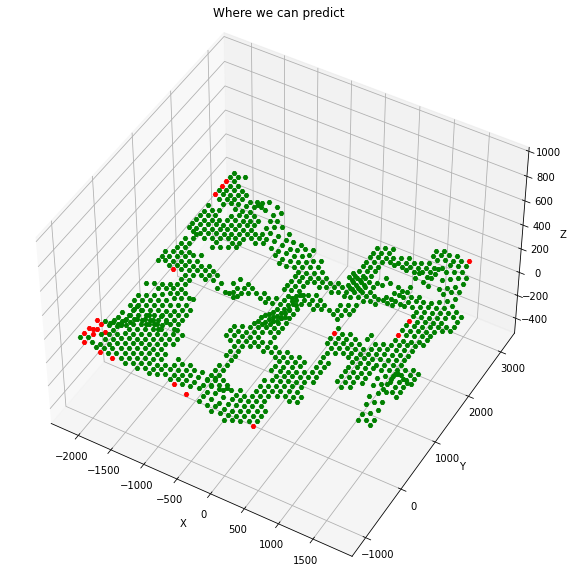

In [12]:
azim = -60
elev = 45

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
for i, cell in enumerate(points):
    col = "green"
    if results[i] == None:
        col = "red"
    ax.scatter(cell[0], cell[1], cell[2], color=col, marker="H")


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-500, 1000)

ax.azim = azim
ax.elev = elev

plt.title("Where we can predict")

plt.show()

As expected, the regression didn't work where we had less samples, this shouldn't pose a problem (for the aforementioned reasons), let's go onward!

We now load the test data

In [14]:
test_samples = None

with open('samples_test.pickle', 'rb') as handle:
    test_samples = pickle.load(handle)

And now we reach the apex of our project: let's predict these movements!

The next function we define is a mixture of our knowledge in probability and in programming: first of all a disclaimer, it isn't in any way perfect (because to do so it would run forever) indeed it uses a heuristic that we fear could skew our data, but that we cannot work with (unless we wanted to wait a minute for each sample, and there are almost 400000 samples).

The heuristic we use is a cutoff: whenever a movement to a cell is lower than some minimum value (which we set to $0.005$) then we prune that branch (and redistribute uniformly its probability over the other possible events, as to keep the overall sum equal to 1). This may seem a silly idea, but it boosts the performance of our system by multiple magnitudes (while, hopefully, keeping the accuracy pretty high).

Another cool trick that we deploy (but that doesn't decrease our accuracy in the slightest) is memoization: it is a method that increases the memory footprint of our system but decreases, again, the runtime of the system when executing multiple predictions (which of course, if we are going through all the dataset, we do). The reasoning is that, since the regressors are already set, if we give the same input two times we should get the same output in both cases, thus it doesn't make sense to rerun the system for the same input. Alas this method precludes one thing: continuous values in input, and that's why we discarded the `team_dir` variable from our explanatory variables set.

With all of these optimizations in mind, a full run of the dataset shortened from multiple hours (or, if we removed both the cutoff and the memoization, probably a couple of days) to just some 5/10 minutes.

In [16]:
def predict_movement(cell_now, cell_from, team, mem=dict(), depth=10, cutoff=0.005):

    tup = (cell_now, cell_from, team, depth)
    if tup in mem:
        return mem[tup]

    if results[cell_now] == None:
        mem[tup] = dict()
        return dict()

    res = None
    temp = pd.DataFrame()
    temp["cell_from"] = pd.Categorical([cell_from], categories=list(range(len(connect_from[cell_now]) + 1)), ordered=False)
    temp["team"] = pd.Categorical([team], categories=[0,1], ordered=False)
    res = results[cell_now].predict(temp).values[0]

    indexed_res = [(val, int(results[cell_now].model._ynames_map[i])) for i,val in enumerate(res)]
    indexed_res.sort()

    kb = dict()

    residual = 0.0
    k_res = 0
    for val,_ in indexed_res:
        if val + residual / (len(indexed_res) - k_res) <= cutoff:
            k_res += 1
            residual += val
        else:
            break

    if k_res < len(indexed_res):
        residual = residual / (len(indexed_res) - k_res)

    j = k_res

    while j < len(indexed_res):
        prob, choice = indexed_res[j]
        prob += residual
        next_cell = cell_now if choice == 0 else connect_to[cell_now][choice - 1]

        if depth > 0:
            next_from = 0 if next_cell == cell_now else connect_from[next_cell].index(cell_now) + 1
            ret = predict_movement(next_cell, next_from, team, mem, depth - 1, cutoff)
            
            for key, value in ret.items():
                kb[key] = kb.get(key, 0) + value * prob
            
        else:
            kb[next_cell] = kb.get(next_cell, 0) + prob

        j += 1

    mem[tup] = kb
    return kb

In [17]:
tot = 0
analyzable = 0
final_predictions = dict()
memoization = dict()
for i,samples in enumerate(test_samples):
    print(i)
    final_predictions[i] = []
    tot += samples.shape[0]
    if results[i] == None:
        continue
    
    analyzable += samples.shape[0]
    for row in samples[["cell_from", "team", "course"]].values:
        pred = predict_movement(i, row[0], row[1], mem=memoization, cutoff=0.005)
        if pred != None:
            lst = list(pred.items())
            lst.sort(key=lambda item: -item[1])
            final_predictions[i].append((row, lst))
        else:
            analyzable -= 1

print(f"Total {tot}, bad {tot - analyzable}, bad on tot {(tot - analyzable) / tot * 100:.03f}%")

with open('predictions_AAA.pickle', 'wb') as handle:
    pickle.dump(final_predictions, handle)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Just 12 bads out of 345823? That's pretty nice. And that's also why we did well not fearing too much about those non-regressed cells, the possible test samples (and thus real situations, we assume) that would require them are so few that an error with them is essentially a rounding problem.

Let's now check our predictions, as you can see we've got an `accumulation` variable which we use to select the cells we want to use in our proposal.
Indeed, if you look at the previous cell, while building our predictions we also sorted the results by their predicted probability. Now we use that sorting to decide which cells to give in our, as we said, proposals for the player's position.

The idea is that, the lower the `accumulation` value we set, the lower the amount of cells that we get in our proposal but, at the same time, the lower also becomes the probability for the player to be present in this proposal. Sort of like in a confidence interval (just with less theoretical backing behind, this seems too complicated for us)!

Why do we do this? Because otherwise we would only get a "wildfire" prediction (doing that wouldn't have much statistical flavour) while we want to have more "spotted" predictions that, while they may be less accurate, are for sure more expressive (in our opinion $50\%$ accuracy with an average proposal of just two cells is much more interesting than $99\%$ accuracy with a hundred cells, sort of like striking a balance between the $\alpha$ and the power of a test!). 

In [13]:
final_predictions = None
with open('predictions.pickle', 'rb') as handle:
    final_predictions = pickle.load(handle)

In [5]:
accumulation = 0.99

p = 0
n = 0
s = 0
correct = 0

for key, lst in final_predictions.items():
    for row, a in lst:
        ssum = 0
        k = 0
        for _, val in a:
            if ssum < accumulation:
                ssum += val
                k += 1
            else:
                break
        if len(a) > 0:
            p += k / len(a)
        s += k
        n += 1

        if row[2][-1] in {cel for cel, _ in a[: k + 1]}:
            correct += 1

print(f"Average decrease from full size {1 - p / n:.3f}")
print(f"Average size of proposal {s / n:.3f}")
print(f"Accuracy {correct / n:.3f}")

Average decrease from full size 0.497
Average size of proposal 68.134
Accuracy 0.914


Thus what we now want to do is to appreciate how much the accuracy and the size of the proposals change based on the `accumulation`, to do so we run the system at multiple levels of `accumulation` and look at a graph of the results

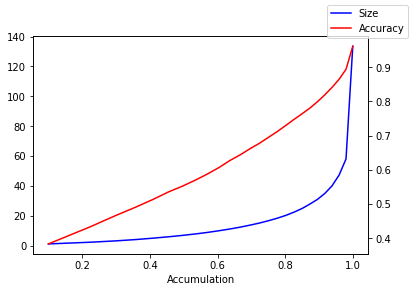

In [19]:
accumulations = np.linspace(.01, 1, 26) ** .5
sizes = np.empty_like(accumulations)
accuracies = np.empty_like(accumulations)

for i, accu in enumerate(accumulations):
    p = 0
    n = 0
    s = 0
    correct = 0

    for key, lst in final_predictions.items():
        for row, a in lst:
            ssum = 0
            k = 0
            for _, val in a:
                if ssum < accu:
                    ssum += val
                    k += 1
                else:
                    break
            if len(a) > 0:
                p += k / len(a)
            s += k
            n += 1

            if row[2][-1] in {cel for cel, _ in a[: k + 1]}:
                correct += 1

    sizes[i] = s / n
    accuracies[i] = correct / n

df = pd.DataFrame({"Accumulation":accumulations, "Size": sizes, "Accuracy": accuracies})

ax = df.plot(x="Accumulation", y="Size", legend=False, color="b")
ax2 = ax.twinx()
df.plot(x="Accumulation", y="Accuracy", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

Interesting... what are we going to do with this knowledge? We don't know!

It seems like a good compromise between accuracy and size may sit near $0.7$, let's check it on a graph.

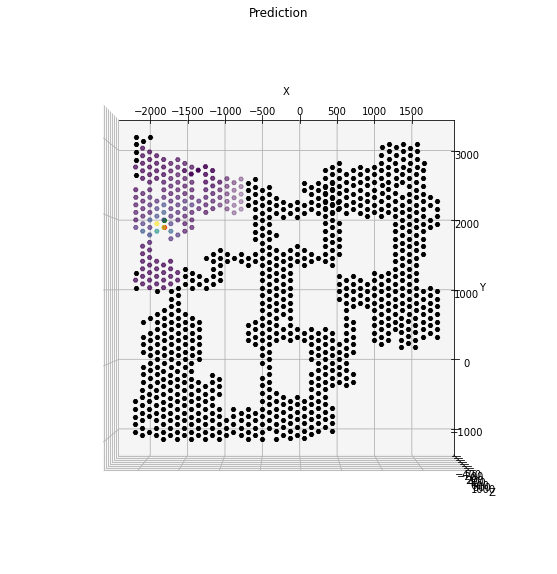

In [25]:
cell_i = 140
accumulation = 1


row, lst = final_predictions[cell_i][2]

ssum = 0
k = 0
for _, val in lst:
    if ssum < accumulation:
        ssum += val
        k += 1
    else:
        break

foo = {val for val in lst[: k + 1]}

azim = -90
elev = 90

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
diff = []
for i, cell in enumerate(points):
    col = "black"
    pr = True
    for item in foo:
        if item[0] == i:
            pr = False
            diff.append((cell[0],cell[1], cell[2], item[1]))
            break
    if pr and cell_i != i and cell_i != row[2][-1]:
        ax.scatter(cell[0], cell[1], cell[2], color=col, marker="H")

    if cell_i == i:
        ax.scatter(cell[0], cell[1], cell[2], color="green", marker="H")

    if i == row[2][-1]:
        ax.scatter(cell[0], cell[1], cell[2], color="red", marker="H")



diff = np.asarray(diff).T
ax.scatter(diff[0], diff[1], diff[2], c=diff[3], cmap="viridis", marker="H")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-500, 1000)

ax.azim = azim
ax.elev = elev

plt.title("Prediction")

plt.show()

Again, very interesting, we can see that there's some sort of non-wildfire-like set that emerges from our proposal... we think that settles it, this procedure, although a little bit rough, seems to work!

We realize that more work could be done to refine it and one could go on trying to get better and better performance/accuracy. But alas this project was *really* taxing on the matter of data collection and preparation and we feel like we've reached a good point so far. Thus it is better to end it here with these interesting conclusions that *could* be picked up by somebody and made better (as most things as always). We hope to have made a good show of this and to have left you satisfied, see you at the exam! 